# Understand Data

In [27]:
import os
from pathlib import Path


#Visulazing data structure

def print_dataset_structure(dataset_path):
    dataset_path = Path(dataset_path)
    print("\nEuroSAT Dataset Structure:")
    print("--------------------------")
    
    total_images = 0
    
    # Get all directories (classes) in the dataset folder
    classes = [d for d in dataset_path.iterdir() if d.is_dir()]
    print(f"Root: {dataset_path.name}")
    
    for class_dir in sorted(classes):
        # Count number of images in each class folder
        num_images = len([f for f in class_dir.glob('*') if f.is_file()])
        total_images += num_images
        
        print(f"├── {class_dir.name} ({num_images} images)")
    print(f"\n\nThe dataset contains {len(classes)} classes.")
    print(f"The dataset contains {total_images} images.")              

dataset_path = r"Desktop/EuroSAT"


print_dataset_structure(dataset_path)


EuroSAT Dataset Structure:
--------------------------
Root: EuroSAT
├── AnnualCrop (3000 images)
├── Forest (3000 images)
├── HerbaceousVegetation (3000 images)
├── Highway (2500 images)
├── Industrial (2500 images)
├── Pasture (2000 images)
├── PermanentCrop (2500 images)
├── Residential (3000 images)
├── River (2500 images)
├── SeaLake (3000 images)


The dataset contains 10 classes.
The dataset contains 27000 images.


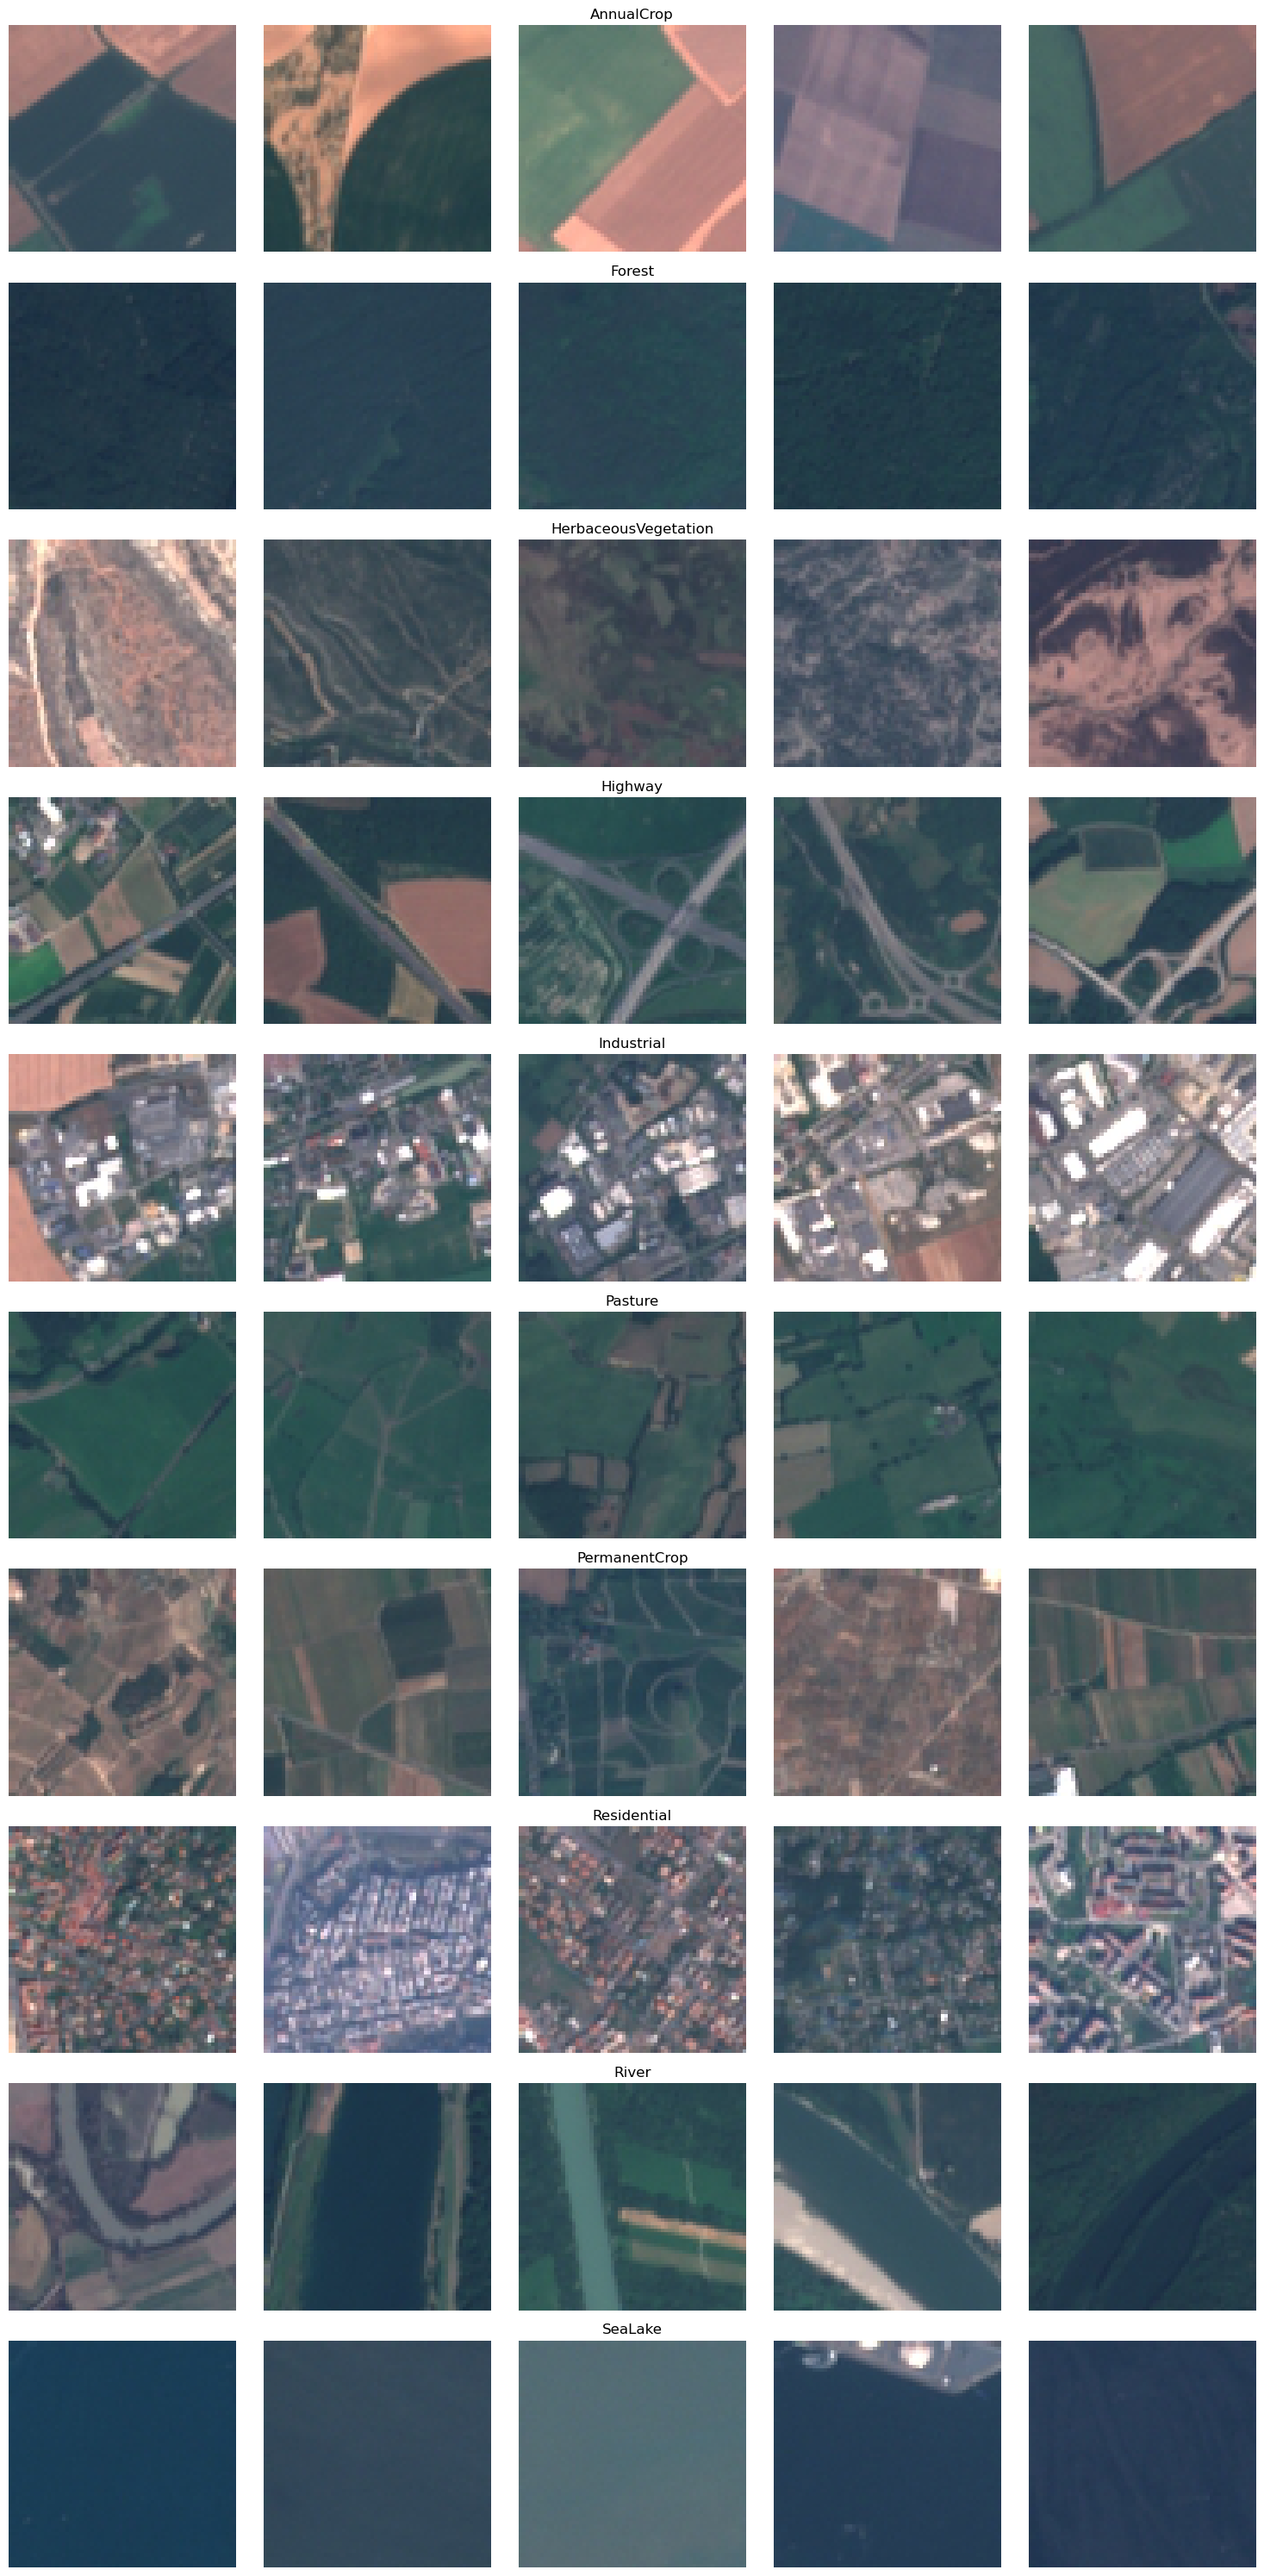

In [16]:
#Visualizing data 

import random
import matplotlib.pyplot as plt
from PIL import Image

# Get all class names (folder names)
class_names = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])

# Plot settings
n_images = 5
n_classes = len(class_names)
plt.figure(figsize=(n_images * 3, n_classes * 3))

# Loop through classes
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    image_files = random.sample(os.listdir(class_path), n_images)
    
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        image = Image.open(img_path)
        
        ax = plt.subplot(n_classes, n_images, class_idx * n_images + i + 1)
        plt.imshow(image)
        ax.set_title(class_name if i == 2 else "")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
#Image Dimension Consistency

from PIL import Image

image_shapes = []
for cls in class_names:
    class_folder = os.path.join(dataset_path, cls)
    for img_file in os.listdir(class_folder)[:10]:  # Check 10 from each class
        img_path = os.path.join(class_folder, img_file)
        with Image.open(img_path) as img:
            image_shapes.append(img.size)

from collections import Counter
shape_counts = Counter(image_shapes)
print("Image shape distribution:", shape_counts)


Image shape distribution: Counter({(64, 64): 100})


In [20]:
#Color Distribution

image_modes = []
for cls in class_names:
    class_folder = os.path.join(dataset_path, cls)
    for img_file in os.listdir(class_folder)[:10]:
        img_path = os.path.join(class_folder, img_file)
        with Image.open(img_path) as img:
            image_modes.append(img.mode)

mode_counts = Counter(image_modes)
print("Image color mode distribution:", mode_counts)


Image color mode distribution: Counter({'RGB': 100})


# Prepare Data

In [22]:
#Split data in water and non-water classes

water_classes = ['River', 'SeaLake']
non_water_classes = [cls for cls in class_names if cls not in water_classes]

### _Image Preprocessing_

In [24]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize(size)         #resize
    return np.array(img).flatten()    #flatten.


### _build the dataset_

In [55]:
X = []
y = []
filenames = []  # Add this list to store image paths

for cls in class_names:
    class_folder = os.path.join(dataset_path, cls)
    label = 1 if cls in water_classes else 0
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img_vector = preprocess_image(img_path)
        
        X.append(img_vector)
        y.append(label)
        filenames.append(img_path) 

X = np.array(X)
y = np.array(y)
filenames = np.array(filenames)

print(f"Dataset size: {X.shape}, Labels: {np.unique(y, return_counts=True)}")


Dataset size: (27000, 4096), Labels: (array([0, 1]), array([21500,  5500]))


### _Dimensionality Reduction_

In [56]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X)

print("Compressed shape:", X_svd.shape)


Compressed shape: (27000, 100)


# Classification

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X_svd, y, filenames, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Non-Water", "Water"]))


              precision    recall  f1-score   support

   Non-Water       0.86      1.00      0.93      4300
       Water       0.98      0.38      0.54      1100

    accuracy                           0.87      5400
   macro avg       0.92      0.69      0.74      5400
weighted avg       0.89      0.87      0.85      5400



#### Overall Accuracy is 87%
    Model correctly classified 87% of all test images (4698 out of 5400).

#### Precision:
            - When predicting "Non-Water", 86% are correct.
            - When predicting "Water", 98% are correct.

#### Recall:
            - Non-Water: Perfect recall (all true Non-Water images were detected).
            - Water: Only 38% of true Water images were found (62% were misclassified as Non-Water).

#### F1-score:
            - Non-Water prediction is robust.
            - Water detection is poor (due to low recall).

# Oversampling with SMOTE


#### Brief Description

_This generates synthetic examples of the minority class (water) to balance training data instead of simply duplicating existing samples._

How **SMOTE** Works:

    Selects a minority class sample (e.g., a "Water" image).

    Finds its k-nearest neighbors (default: k=5).

    Creates synthetic examples by interpolating between the sample and its neighbors.


Works well with Small minority class like "Water" in our case.

In [58]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", np.bincount(y_resampled))


Resampled class distribution: [17200 17200]


In [59]:
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Non-Water", "Water"]))


              precision    recall  f1-score   support

   Non-Water       0.88      0.97      0.92      4300
       Water       0.78      0.47      0.59      1100

    accuracy                           0.87      5400
   macro avg       0.83      0.72      0.75      5400
weighted avg       0.86      0.87      0.85      5400



#### Still have low water recall.

# Class Weighting

#### Brief Description

_Class weighting is a technique to handle class imbalance by assigning higher importance (weights) to the minority class during model training. This forces the algorithm to pay more attention to misclassifications of the underrepresented "Water"._

For exemple : for a (1:4) ratio, The loss function to minimize becomes $$ 
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{Non-Eau}} + 4 \cdot \mathcal{L}_{\text{Eau}}
$$

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Non-Water", "Water"]))


              precision    recall  f1-score   support

   Non-Water       0.86      1.00      0.92      4300
       Water       0.97      0.37      0.54      1100

    accuracy                           0.87      5400
   macro avg       0.92      0.69      0.73      5400
weighted avg       0.88      0.87      0.85      5400



#### Manual Weight Tuning

In [45]:
weight_trials = {
    '1:6'   : {0:1, 1:6},
}

for name, weights in weight_trials.items():
    clf = RandomForestClassifier(class_weight=weights, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\nWeights {name}:")
    print(classification_report(y_test, y_pred))


Weights 1:6:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      4300
           1       0.97      0.38      0.54      1100

    accuracy                           0.87      5400
   macro avg       0.91      0.69      0.73      5400
weighted avg       0.88      0.87      0.85      5400



### I have tried few combinations but the water recall is stucked at ~0.38

# Visualizing Misscalifications (work with the model with water_recall=47%)

In [78]:
import numpy as np

false_negatives_idx = np.where((y_test == 1) & (y_pred == 0))[0]
print(f"Number of false negatives: {len(false_negatives_idx)}")


Number of false negatives: 582


In [76]:
def plot_false_negatives(image_paths, indices, num_images, max_per_row=5):

    # Limit to the requested number of images
    indices = indices[:num_images]
    num_images = len(indices)  # In case there are fewer than requested
    
    # Calculate grid dimensions
    n_rows = (num_images + max_per_row - 1) // max_per_row
    n_cols = min(num_images, max_per_row)
    
    plt.figure(figsize=(15, 3 * n_rows))  # Adjust height based on rows
    
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i + 1)
        img = Image.open(image_paths[idx])
        plt.imshow(img)
        plt.title(f"FN #{i+1}")
        plt.axis('off')
    
    plt.suptitle(f"False Negatives (Water predicted as Non-Water)\n"
                 f"Showing {num_images} of {len(indices)} total", 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

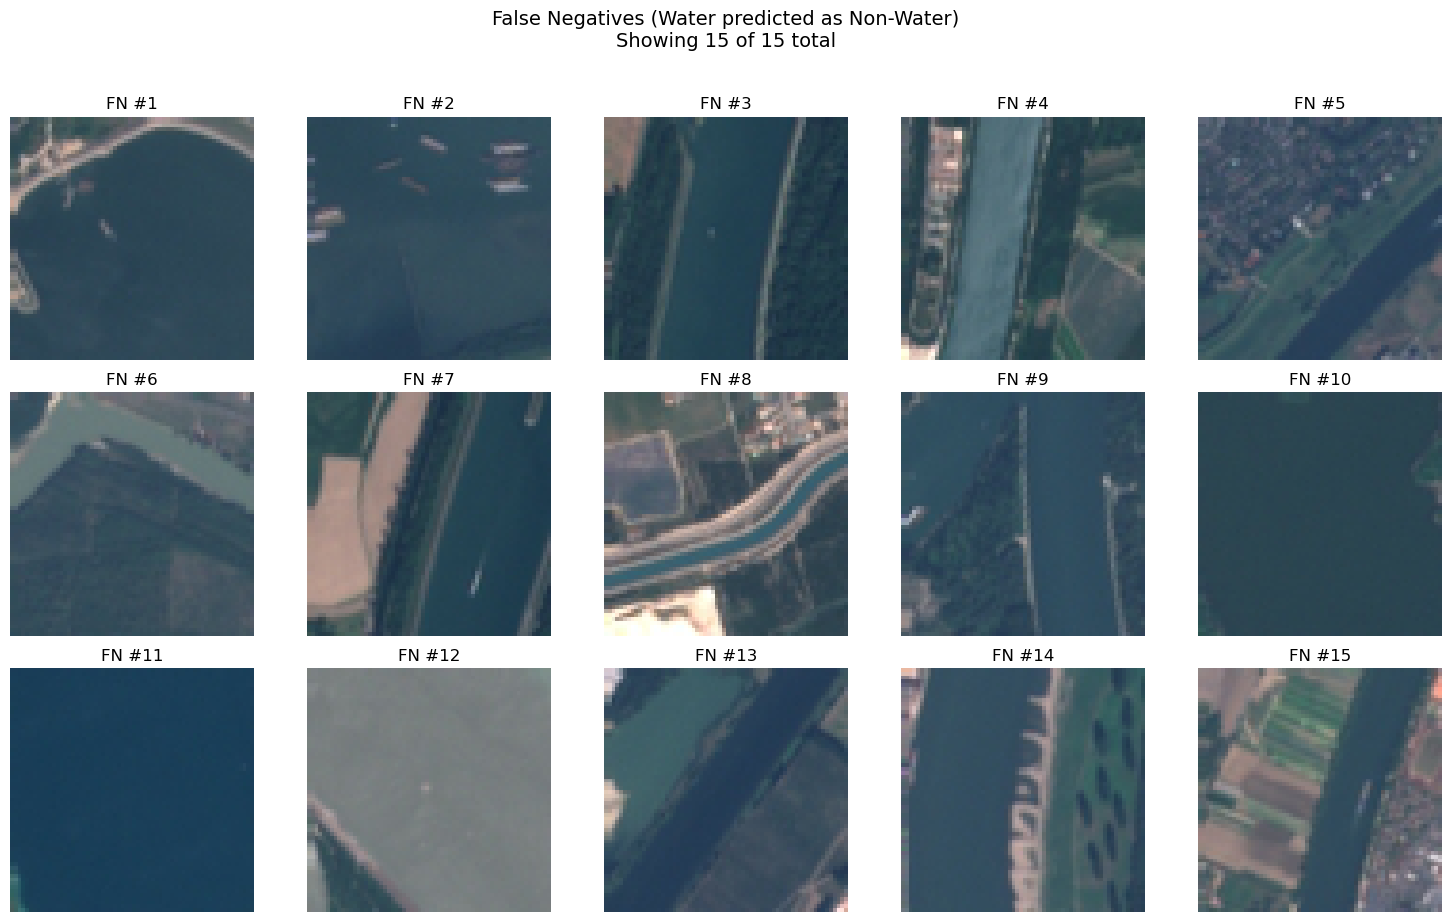

In [77]:
plot_false_negatives(filenames_test, false_negatives_idx,15)

# Increasing the number of singular values

In [79]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42)
X_svd = svd.fit_transform(X)

print("Compressed shape:", X_svd.shape)


Compressed shape: (27000, 1000)


In [80]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X_svd, y, filenames, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Non-Water", "Water"]))


              precision    recall  f1-score   support

   Non-Water       0.88      0.98      0.93      4300
       Water       0.86      0.47      0.61      1100

    accuracy                           0.88      5400
   macro avg       0.87      0.72      0.77      5400
weighted avg       0.87      0.88      0.86      5400



# Work with RGB 

In [94]:

def preprocess_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert("RGB")  # 3 channels: Red, Green, Blue
    img = img.resize(size)         #resize
    return np.array(img).flatten()    #flatten.

In [95]:
X = []
y = []
filenames = []  # Add this list to store image paths

for cls in class_names:
    class_folder = os.path.join(dataset_path, cls)
    label = 1 if cls in water_classes else 0
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img_vector = preprocess_image(img_path)

        X.append(img_vector)
        y.append(label)
        filenames.append(img_path) 

X = np.array(X)
y = np.array(y)
filenames = np.array(filenames)

print(f"Dataset size: {X.shape}, Labels: {np.unique(y, return_counts=True)}")


Dataset size: (27000, 12288), Labels: (array([0, 1]), array([21500,  5500]))


In [96]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X)

print("Compressed shape:", X_svd.shape)


Compressed shape: (27000, 100)


In [97]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X_svd, y, filenames, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Non-Water", "Water"]))


              precision    recall  f1-score   support

   Non-Water       0.91      0.95      0.93      4300
       Water       0.75      0.64      0.69      1100

    accuracy                           0.88      5400
   macro avg       0.83      0.79      0.81      5400
weighted avg       0.88      0.88      0.88      5400



# CNN Feature Extraction

#### Brief Description

_Convolutional Neural Networks (CNNs) perform feature extraction through a hierarchical process that automatically learns spatial hierarchies of patterns from input data (images)._

This is done through:

    Convolutional layer : involves sliding a small window (called a kernel or filter) across the input data and computing the dot product between the values in the kernel and the input at each position. This process creates a feature map that represents detected features in the input.

    Activation layer : where an activation function is applied to the output of a convolutional layer. This function introduces non-linearity, allowing the network to learn complex patterns in the data.

    Pooling layer : reduce the spatial dimensions of feature maps, decreasing the data volume and computational complexity while retaining important information.

    

In [101]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np

# Use this instead of preprocess_image
def cnn_preprocess(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # Convert to [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406],  # Mean for ImageNet
                             [0.229, 0.224, 0.225]) # Std for ImageNet
    ])
    return transform(img)


X = []
y = []
filenames = []

# Load pretrained ResNet18 and remove final classifier
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Keep feature extractor only
model.eval()


for cls in class_names:
    class_folder = os.path.join(dataset_path, cls)
    label = 1 if cls in water_classes else 0

    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)

        try:
            img_tensor = cnn_preprocess(img_path).unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                features = model(img_tensor).squeeze().numpy()  # Shape: (512,)
            X.append(features)
            y.append(label)
            filenames.append(img_path)
        except Exception as e:
            print(f"Skipping {img_path} due to error: {e}")

X = np.array(X)
y = np.array(y)
filenames = np.array(filenames)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels: {np.unique(y, return_counts=True)}")


C:\Users\EB.YEAGER\miniconda3\envs\tajwid\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\EB.YEAGER\miniconda3\envs\tajwid\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\EB.YEAGER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 15.3MB/s]


Feature matrix shape: (27000, 512)
Labels: (array([0, 1]), array([21500,  5500]))


# Classifier (XGBoost)

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    X, y, filenames, test_size=0.2, stratify=y, random_state=42
)

clf = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Non-Water", "Water"]))


C:\Users\EB.YEAGER\miniconda3\envs\tajwid\lib\site-packages\xgboost\training.py:183: UserWarning: [22:29:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

   Non-Water       0.98      0.99      0.99      4300
       Water       0.97      0.91      0.94      1100

    accuracy                           0.98      5400
   macro avg       0.97      0.95      0.96      5400
weighted avg       0.98      0.98      0.98      5400

